In [1]:
cd C:\Users\USER\Quant

C:\Users\USER\Quant


In [2]:
import Quant as Quant
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from dateutil.relativedelta import relativedelta
import warnings
warnings.filterwarnings(action='ignore')

In [3]:
path = '재무데이터.xlsx'
path_price = '수정주가.csv'
path_mkt = '시총데이터.csv'
path_endmonth = '결산월.csv'
path_kospiyn = '거래소데이터.csv'
path_delist_and_stop = '상장폐지데이터.csv'

In [4]:
cleaned_data = Quant.preprocessing_path(path)
cleaned_price = Quant.preprocessing_price(path_price)
cleaned_kospiyn = Quant.preprocessing_kospiyn(path_kospiyn)
cleaned_mkt = Quant.preprocessing_mktdata(path_mkt)
delist_data, stop_data = Quant.preprocessing_stop_and_delist(path_delist_and_stop)
cleaned_endmonth = Quant.preprocessing_period(path_endmonth)

In [6]:
def price_after_delist(cleaned_price, delist_data) :
    ##############################################
    # 상장폐지 이후가격을 0으로 만들어주는 함수  #
    ####################################################
    P = cleaned_price.copy()                           #
    x1_list = delist_data.index                        # 상장 폐지된 종목들의 종목번호 인덱스
    x2_list = list(delist_data[delist_data.columns[0]])# 해당 종목의 상장폐지일자   
    lst = []                                           #
    for i in range(len(x1_list)) :                     #
        x1, x2 = x1_list[i], x2_list[i]       ###################
        P[x1][x2:] = np.zeros(len(P[x1][x2:]))#상폐이후의가격=0 #  
        lst.append(P[x1])                ########################
    p1 = P[P.columns.difference(x1_list)]#현재 상폐안된 데이터  #
    p2 = pd.concat(lst,axis = 1)         #기존에 상폐된 데이터  #
    p = pd.concat([p1,p2],axis = 1)      # 두개를 합치기        #
    #############################################################
    return p[P.columns]

def preprocessing_backtest(cleaned_data, cleaned_price, cleaned_mkt, 
                           delist_data, stop_data) :
    ############################################
    # 1. 1일 수익률이 극단적인 종목들 제외하기 #
    # 2. 상장폐지 이후 가격을 0으로 만들어주기 #
    # 3. Monthly 데이터로 바꿔서 리턴하기      #
    ############################################
    extreme_return = (cleaned_price.pct_change() > 3).max(0)
    not_extreme = extreme_return[extreme_return == False].index
    P = cleaned_price[not_extreme].resample('M').last()
    STOP = stop_data['거래정지여부'].loc[not_extreme].T.resample('M').last()
    DELIST = delist_data.loc[delist_data.index.intersection(not_extreme)]
    FINANCE = cleaned_data.loc[not_extreme]
    P = price_after_delist(P, DELIST)
    MKT = cleaned_mkt[not_extreme].resample('M').last()
    return FINANCE, P, MKT, DELIST, STOP

def calculate_data_Q_before_2001(rebalance_day):
    ####################################################
    # 1. 2001년 이전의 경우 분기데이터가 존재하지 않음 #
    # 2. 따라서 reference 재무데이터는 사업보고서      #
    # 3. 사업보고서 역시 5월까지 거의 안나옴           #
    ####################################################
    reference_year = rebalance_day.year - 2 if rebalance_day.month <= 5 else rebalance_day.year - 1 
    data_Q = str(reference_year)+'-12-31'
    return pd.to_datetime(data_Q)

def calculate_data_Q_after_2001(rebalance_day):
    ##################################################
    # 1. 2001년 이후로는 분기 보고서를 이용 가능하다.#
    # 1. 직전 사업보고서는 최대 91 + 30일 뒤에 나옴  #
    # 2. 분기보고서는 최대 46일 + 30일 뒤에 나옴     #
    ##################################################
    year = rebalance_day.year
    bQ3 = pd.to_datetime(str(year-1) + '-09-30')
    bQ4 = pd.to_datetime(str(year-1)+'-12-31')
    Q1 = pd.to_datetime(str(year)+'-03-31')
    Q2 = pd.to_datetime(str(year)+'-06-30')
    Q3 = pd.to_datetime(str(year)+'-09-30')
    bQ4_report_day = bQ4 + relativedelta(days = 121)
    Q1_report_day = Q1 + relativedelta(days = 76)
    Q2_report_day = Q2 + relativedelta(days = 76)
    Q3_report_day = Q3 + relativedelta(days = 76)
    if rebalance_day <= bQ4_report_day :
        data_Q = bQ3
    elif rebalance_day > bQ4_report_day and rebalance_day <= Q1_report_day :
        data_Q = bQ4
    elif rebalance_day > Q1_report_day and rebalance_day <= Q2_report_day :
        data_Q = Q1
    elif rebalance_day > Q2_report_day and rebalance_day <= Q3_report_day :
        data_Q = Q2
    else :        
        data_Q = Q3
    return data_Q

def calculate_data_Q(rebalance_day) :
    #######################################################
    # 1. 2001년 이전이라면 사업보고서 기준날짜를 출력한다.#
    # 2. 2001년 이후라면 분기보고서 기준날짜를 출력한다.  #
    #######################################################
    rebalance_day = pd.to_datetime(rebalance_day)
    if rebalance_day < pd.to_datetime('2001-05-01') :
        data_Q = calculate_data_Q_before_2001(rebalance_day)
    else :
        data_Q = calculate_data_Q_after_2001(rebalance_day)
    return data_Q

def available_stock(today, FINANCE, DELIST, cleaned_kospiyn,STOP) :
    ############################################
    # 1.이미 상장폐지된 종목들 제거하기 ########    
    # 2.오늘 KOSPI 시장에 상장된 종목만 꺼내기 #    
    # 3.오늘 거래정지되지 않은 종목만 꺼내기   #   
    ############################################
    one_before = pd.to_datetime(today) - relativedelta(years = 1)
    
    before_DELIST = DELIST[DELIST['상장폐지일자']<today].index   # 1.
    not_delist = FINANCE.index.difference(before_DELIST)         #

    KYN = cleaned_kospiyn.resample('M').last().fillna(method = 'ffill',limit = 2) # 2.
    today_kospiyn = KYN[one_before:today].iloc[-1]                                #
    kospi_index = today_kospiyn[today_kospiyn == 1].index                         #

    isstop = STOP[one_before:today].iloc[-1] # 3.
    not_stopped = isstop[isstop !=1].index   #
    stock_index = not_delist.intersection(kospi_index).intersection(not_stopped)         
    return stock_index

def vectorized_choose_str(Strategy, FINANCE, MKT, PRICE, STOP, rebalance_day_list,data_Q_list,cleaned_kospiyn, DELIST, n) :
    ###################################################################
    ## 종목뽑아주는 함수를 today, data_Q 여러개에 대해서 vectorize한다.
    ###################################################################
    def Choose_Str( today, data_Q , 
                    Strategy = Strategy, FINANCE = FINANCE, 
                    PRICE = PRICE, MKT = MKT,DELIST = DELIST,STOP = STOP,
                   cleaned_kospiyn =cleaned_kospiyn, n=n ) :
        stock_index = available_stock(today, FINANCE, DELIST, cleaned_kospiyn,STOP)
        Str_data = Strategy(cleaned_data = FINANCE.loc[stock_index] , 
                            cleaned_mkt = MKT[stock_index],data_date = data_Q, 
                            today = today, n = n, cleaned_price = PRICE[stock_index])
        my_index = Str_data.index
        return my_index    
    
    return np.vectorize(Choose_Str)(rebalance_day_list, data_Q_list)

def my_port_value(choosed_stock_index,start_day , Before_STOP_VALUE, 
                  rebalance_freq , PRICE, initial_money,
                  initial_money_except_stop,STOP):

    start = start_day
    end = start + pd.DateOffset(months = rebalance_freq, day = 31)   
    ###########################################################################
    # 1. choosed_name = 전략으로 선택된 종목중 이전기 거래정지 종목이 아닌 종목 
    # 2. 종목으로 뽑혔지만 주가가 nan인 것 제외
    # 3. STOP_P = 이전기에 정지된 종목들의 이번기 가격                           
    # 4. P = 전략으로 선택된 종목들의 가격 (0인경우 제외)                       
    # 5. N = 선택된 나머지 종목 수   
    ###########################################################################
    choosed_name = choosed_stock_index.difference(Before_STOP_VALUE.columns)
    choosed_name = PRICE[choosed_stock_index][start:end].iloc[0].dropna().index
    STOP_P = PRICE[Before_STOP_VALUE.columns][start:end]
    P = PRICE[choosed_name][start:end]
    P_is_not_0 = P.iloc[0] != 0
    P_is_not_na = P_is_not_0[P_is_not_0.isna() == False]
    not_0 = P_is_not_0[P_is_not_0 == True].index
    P = P[not_0]
    N = len(P.columns)
    #######################################################################
    # 6. PF = 거래정지 안된 포트폴리오 종목들의 가치                       
    # 7. STOP_PF = 기존에 포트폴리오의 거래정지된 종목들의 시간에 따른 가치
    # 8. Total_PF = PF, STOP_PF를 합친 포트폴리오 종목들의 가치            
    # 9. NEW_STOP_INDEX = 이번기에 새롭게 거래정지된 종목                  
    #######################################################################    
    PF = initial_money_except_stop * 1/N * P/P.iloc[0]
    STOP_PF = Before_STOP_VALUE.iloc[-1] * STOP_P/STOP_P.iloc[0]
    Total_PF = pd.concat([PF,STOP_PF],axis = 1)    
    S = STOP[Total_PF.columns][start: end].iloc[-1] == 1
    NEW_STOP_INDEX = S[S == True].index
    Total_Value = pd.Series(Total_PF.sum(1))               
    
    Before_STOP_VALUE = Total_PF[NEW_STOP_INDEX]

    initial_money = Total_Value.iloc[-1]
    initial_money_except_stop = initial_money - Before_STOP_VALUE.iloc[-1].sum()    
    
    return Total_Value, Before_STOP_VALUE,initial_money , initial_money_except_stop

def backtest(Strategy , start_day, end_day, cleaned_data, cleaned_price, cleaned_mkt, delist_data, stop_data,
             cleaned_kospiyn,rebalance_freq = 6, number_of_stock = 50, initial_money = 10000) :
    #############기본 셋팅 #######################
    # 1. 뽑을 종목 숫자                          #
    # 2. 포트폴리오의 총 가치를 표시할 DataFrame #
    # 3. 거래정지된 종목을 표시할 DataFrame      #
    # 4. 거래정지 제외하고 투자가치의 합을 표시  #
    ##############################################
    n = number_of_stock    
    today , end_day = pd.to_datetime(start_day), pd.to_datetime(end_day)
    PF_Value = pd.DataFrame([])
    Before_STOP_VALUE = pd.DataFrame([], index = [today])    
    initial_money_except_stop = initial_money -Before_STOP_VALUE.iloc[-1].sum()
    KOSPIYN = cleaned_kospiyn.resample('M').last().fillna(method = 'ffill', limit = 1) 
    
    ################################################################
    # 5. 리벨런스 날짜 and 재무데이터 기준 날짜를 모두 뽑는다.     #
    # 6. 극단적 종목 제외하는 전처리                               #
    # 7. 리벨런스 날짜 and 재무데이터 기준 날짜에 맞춰서 종목 추출 #
    ################################################################
    rebalance_day_list = list(pd.date_range(start_day ,end_day, freq = 'M')[::rebalance_freq]) 
    data_Q_list = np.vectorize(calculate_data_Q)(rebalance_day_list)
    FINANCE, PRICE, MKT, DELIST, STOP = preprocessing_backtest(cleaned_data, cleaned_price, 
                                                               cleaned_mkt, delist_data, 
                                                               stop_data)
    choosed_stock_list = list(vectorized_choose_str(Strategy, FINANCE, MKT, 
                                                    PRICE, STOP, rebalance_day_list,
                                                    data_Q_list,KOSPIYN,DELIST, n))
    for i in range(len(rebalance_day_list)) :
        choosed_stock_index = choosed_stock_list[i]
        start_day = rebalance_day_list[i]
        #######################################################
        # 8. 추출된 종목 기준으로 포트폴리오 가치를 계산한다. #
        # 9. 거래정지 종목 가치도 계산한다.                   #
        # 10. 포트폴리오 가치 데이터를 반복해서 합쳐준다.     #
        #######################################################
        VALUE, Before_STOP_VALUE,initial_money , initial_money_except_stop = my_port_value(choosed_stock_index, start_day,
                                                                                           Before_STOP_VALUE,
                                                                                           rebalance_freq, PRICE, 
                                                                                           initial_money,
                                                                                           initial_money_except_stop, STOP)
        PF_Value = pd.concat([PF_Value, VALUE.iloc[:-1]],axis = 0)
    PF_Value.columns = ['Port_Value']
    return PF_Value.astype(np.int64)

In [8]:
start_day = '1983-06-30'
end_day = '2021-01-31'
PF  = backtest(Quant.F_score , start_day, end_day, cleaned_data, cleaned_price, cleaned_mkt, delist_data, stop_data,cleaned_kospiyn,
              rebalance_freq = 3, number_of_stock = 50, initial_money = 10000)

<BarContainer object of 38 artists>

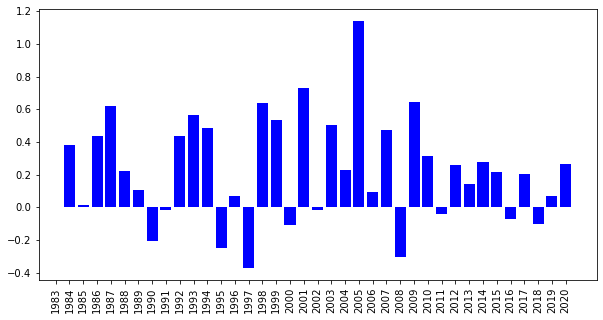

In [11]:
plt.figure(figsize = (10,5))
ind= np.arange(len(PF.resample('Y').last().pct_change()))
real_index = list(pd.Series(PF.resample('Y').last().pct_change().index).apply(lambda x : x.year))
plt.xticks(ind, real_index, rotation='vertical')
plt.bar(ind,PF.resample('Y').last().pct_change()['Port_Value'], color = 'blue')

 # 나머지 함수도 .py로 만들기(spyder를 활용하시오.)